# IAU Projekt

# Fáza 2 - predspracovanie údajov

V tejto fáze sa od Vás očakáva:
* Realizujte predspracovanie údajov pre strojové učenie. Výsledkom bude upravená dátová sada vo formáte csv alebo tsv, kde jedno pozorovanie musí byť opísané jedným riadkom.
* V 3. fáze budeme pracovať s algoritmami strojového učenia, ktorých implementácia v scikit-learn podporuje len numerické dáta. To vedie k tomu že treba niečo spraviť s nenumerickými dátami.
* Replikovateľnosť predspracovania na trénovacej a testovacej množine dát.

Keď sa predspracovaním mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), je možné že treba znovu zrealizovať podstatné časti prieskumnej analýzy a opakovane podľa Vašej potreby. Bodovanie znovu za EDA už nebudeme, zmeny ale zdokumentujte. Problém s dátami môžete riešiť iteratívne v každej fáze aj vo všetkých fázach podľa vlastnej potreby.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sm_stats

import datetime
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import percentile

In [2]:
def frombirthtoage(born):
    now = datetime.date.today()
    return now.year - born.year - ((now.month, now.day) < (born.month, born.day))

In [3]:
labor = pd.read_csv("046/labor.csv", sep='\t')
labor.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
labor = labor.drop(["index", "name"], axis=1)
smoker_encoding = {"Y": 1, "N": 0, "yes": 1, "no": 0}
labor["smoker"].replace(smoker_encoding, inplace=True)
ce_ordinal_labor = ce.OrdinalEncoder(cols=["relationship"])
labor = ce_ordinal_labor.fit_transform(labor)

profiles = pd.read_csv("046/profiles.csv", sep='\t')
profiles.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
profiles["race"].replace({"black": "Black", "white": "White", "blsck": "Black"}, inplace=True)
profiles["birthdate"] = pd.to_datetime(profiles['birthdate'], utc=False)
ce_ordinal_profiles = ce.OrdinalEncoder(cols=["race", "blood_group", "sex"])
profiles = ce_ordinal_profiles.fit_transform(profiles)
ages = profiles['birthdate'].apply(lambda d: frombirthtoage(d))
profiles = profiles.assign(age=ages.values)
# profiles = profiles.drop(["residence", "job", "company", "name", "birthdate"], axis=1)

merged = pd.merge(profiles, labor, how='outer', on='ssn')
merged = merged.drop(["ssn"], axis=1)


C:\Users\PeterSmrecek\Documents\IAU-repository\IAU-virtual\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [4]:
merged.head()

,index,race,residence,job,birthdate,company,blood_group,sex,name,age,...,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
0,0,1,"108 Pham Loaf\nNew Shelby, IN 31526",Magazine features editor,2007-09-11,"Reynolds, Stewart and Tanner",1,1,Laura Valentine,14,...,6.93051,6.07205,11.27999,0.0,44.47642,8.86713,0,1,26.77151,5.62532
1,0,1,"108 Pham Loaf\nNew Shelby, IN 31526",Magazine features editor,2007-09-11,"Reynolds, Stewart and Tanner",1,1,Laura Valentine,14,...,6.54612,9.31958,11.65206,1.0,57.12059,10.57140,0,2,38.28069,6.59275
2,0,1,"108 Pham Loaf\nNew Shelby, IN 31526",Magazine features editor,2007-09-11,"Reynolds, Stewart and Tanner",1,1,Laura Valentine,14,...,6.91541,5.98328,9.13539,1.0,16.95110,7.30150,0,4,52.93857,8.58363
3,0,1,"108 Pham Loaf\nNew Shelby, IN 31526",Magazine features editor,2007-09-11,"Reynolds, Stewart and Tanner",1,1,Laura Valentine,14,...,6.49755,6.91512,8.46192,0.0,63.86999,8.47060,0,4,48.94005,7.28386
4,1,2,"2246 Tammy Cliffs Apt. 057\nNorth Kim, MI 55878","Investment banker, operational",1971-05-20,Mcdonald-White,2,1,Angela Sullivan,50,...,7.88035,7.00488,5.96198,1.0,42.66862,6.25355,0,3,60.53571,9.03697


## 1. Integrácia a čistenie dát (5b)

Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
* Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie z nasledujúcich podskupín:
    * odstránenie pozorovaní s chýbajúcimi údajmi
    * nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
* Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    * odstránenie vychýlených (odľahlých) pozorovaní
    * nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

### Chýbajúce dáta

In [5]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         10002 non-null  int64         
 1   race          10002 non-null  int32         
 2   residence     10002 non-null  object        
 3   job           10002 non-null  object        
 4   birthdate     10002 non-null  datetime64[ns]
 5   company       10002 non-null  object        
 6   blood_group   10002 non-null  int32         
 7   sex           10002 non-null  int32         
 8   name          10002 non-null  object        
 9   age           10002 non-null  int64         
 10  weight        10002 non-null  float64       
 11  hemoglobin    9972 non-null   float64       
 12  alp           9972 non-null   float64       
 13  etytr         9972 non-null   float64       
 14  alt           9971 non-null   float64       
 15  erytrocyty    9972 non-null   float6

In [6]:
merged.shape[0] - merged.dropna().shape[0]

330

In [7]:
merged.isnull().sum()

index            0
race             0
residence        0
job              0
birthdate        0
company          0
blood_group      0
sex              0
name             0
age              0
weight           0
hemoglobin      30
alp             30
etytr           30
alt             31
erytrocyty      30
hbver           30
hematokrit      30
indicator        0
er-cv           30
leukocyty       30
smoker           0
relationship     0
ast             30
trombocyty      30
dtype: int64

In [8]:
merged.isnull().sum().sum()

331

In [9]:
print("Chýbajúce dáta tvoria {:.3f}% dát".format(merged.isnull().sum().sum() / merged.shape[0] * 100))

Chýbajúce dáta tvoria 3.309% dát


#### Odstránenie pozorovaní s chýbajúcimi údajmi

In [10]:
merged_withoutNA = merged.dropna()

In [11]:
merged_withoutNA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9672 entries, 0 to 10001
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         9672 non-null   int64         
 1   race          9672 non-null   int32         
 2   residence     9672 non-null   object        
 3   job           9672 non-null   object        
 4   birthdate     9672 non-null   datetime64[ns]
 5   company       9672 non-null   object        
 6   blood_group   9672 non-null   int32         
 7   sex           9672 non-null   int32         
 8   name          9672 non-null   object        
 9   age           9672 non-null   int64         
 10  weight        9672 non-null   float64       
 11  hemoglobin    9672 non-null   float64       
 12  alp           9672 non-null   float64       
 13  etytr         9672 non-null   float64       
 14  alt           9672 non-null   float64       
 15  erytrocyty    9672 non-null   float64

<AxesSubplot:>

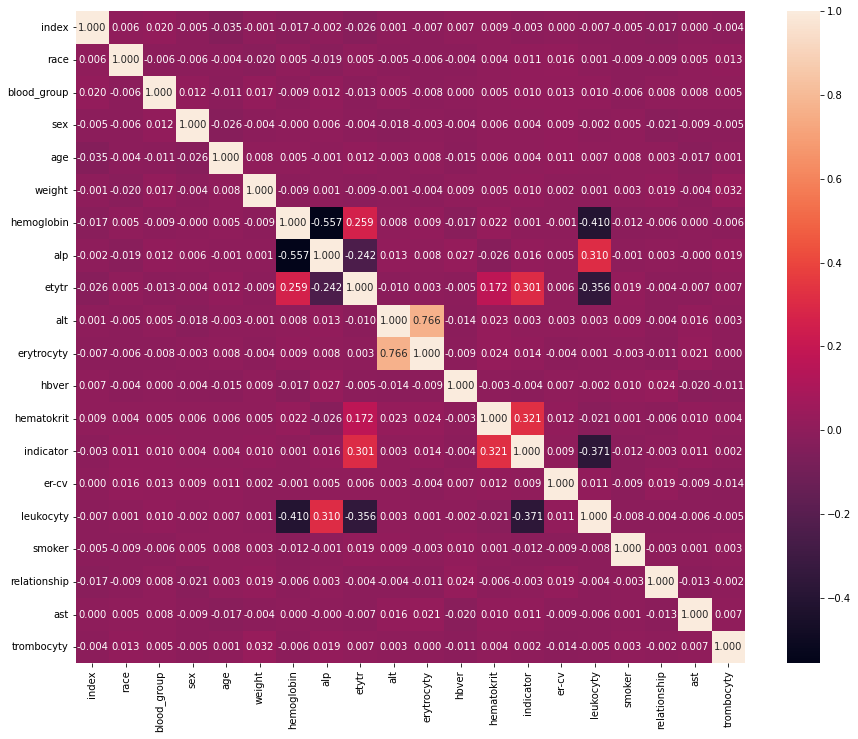

In [12]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged.corr(), ax=ax, annot=True, fmt=".3f")

<AxesSubplot:>

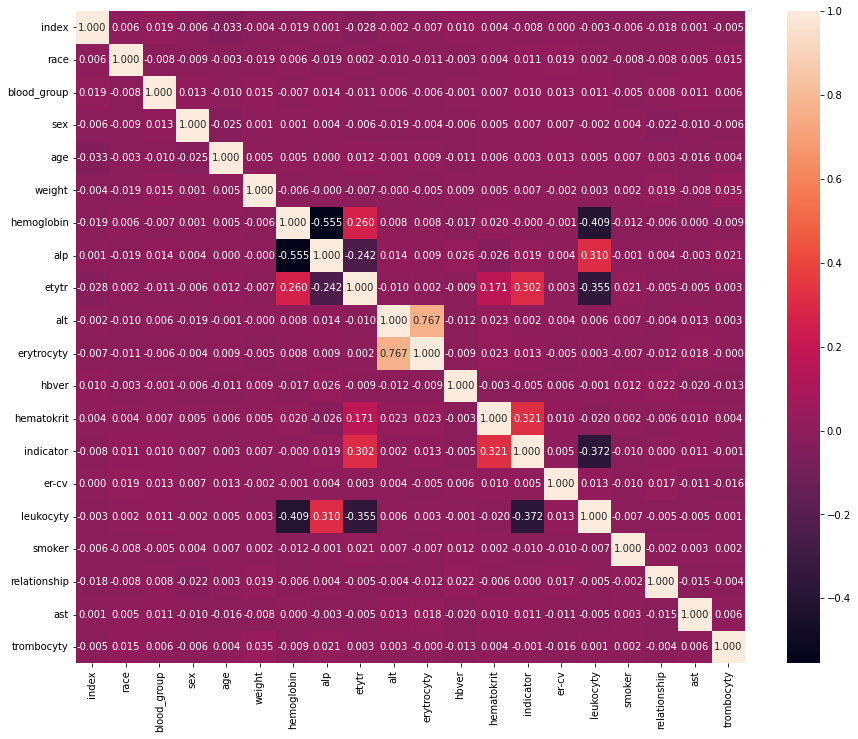

In [13]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_withoutNA.corr(), ax=ax, annot=True, fmt=".3f")

Po odstránení chýbajúcich hodnôt sa nič významné nezmienilo

#### Nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN

In [14]:
na_cols = ["hemoglobin", "alp", "etytr", "alt", "erytrocyty", "hbver", "hematokrit", "er-cv", "leukocyty", "ast", "trombocyty"] 

In [15]:
# def sex_diff(col):
#     print("M ", col, ": ", merged[merged["sex"] == 0][col].mean())
#     print("F ", col, ": ", merged[merged["sex"] == 1][col].mean())

# for col in na_cols: sex_diff(col)

In [16]:
def replaceNaN(original_merged, strategy, na_cols):
    new_merged = original_merged.copy()
    if strategy == "kNN":
        imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
#         imp_strategy = KNNImputer()
    elif strategy == "mean" or strategy == "median":    
        imp_strategy = SimpleImputer(missing_values=np.nan, strategy=strategy)
    else:
        raise Exception("Chybny argument strategy")
    for col in na_cols:
        new_merged[col] = imp_strategy.fit_transform(new_merged[[col]])
    return new_merged
    

##### Nahradenie priemerom

In [17]:
merged_mean = replaceNaN(merged, "mean", na_cols)
merged_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         10002 non-null  int64         
 1   race          10002 non-null  int32         
 2   residence     10002 non-null  object        
 3   job           10002 non-null  object        
 4   birthdate     10002 non-null  datetime64[ns]
 5   company       10002 non-null  object        
 6   blood_group   10002 non-null  int32         
 7   sex           10002 non-null  int32         
 8   name          10002 non-null  object        
 9   age           10002 non-null  int64         
 10  weight        10002 non-null  float64       
 11  hemoglobin    10002 non-null  float64       
 12  alp           10002 non-null  float64       
 13  etytr         10002 non-null  float64       
 14  alt           10002 non-null  float64       
 15  erytrocyty    10002 non-null  float6

<AxesSubplot:>

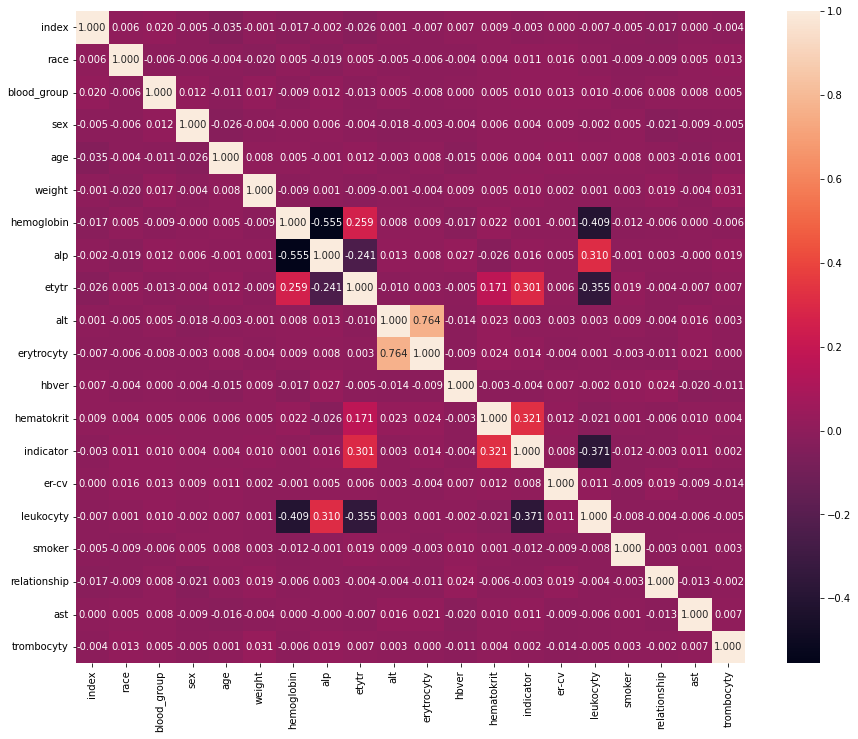

In [18]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_mean.corr(), ax=ax, annot=True, fmt=".3f")

##### Nahradenie mediánom

In [19]:
merged_median = replaceNaN(merged, "median", na_cols)
merged_median.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         10002 non-null  int64         
 1   race          10002 non-null  int32         
 2   residence     10002 non-null  object        
 3   job           10002 non-null  object        
 4   birthdate     10002 non-null  datetime64[ns]
 5   company       10002 non-null  object        
 6   blood_group   10002 non-null  int32         
 7   sex           10002 non-null  int32         
 8   name          10002 non-null  object        
 9   age           10002 non-null  int64         
 10  weight        10002 non-null  float64       
 11  hemoglobin    10002 non-null  float64       
 12  alp           10002 non-null  float64       
 13  etytr         10002 non-null  float64       
 14  alt           10002 non-null  float64       
 15  erytrocyty    10002 non-null  float6

<AxesSubplot:>

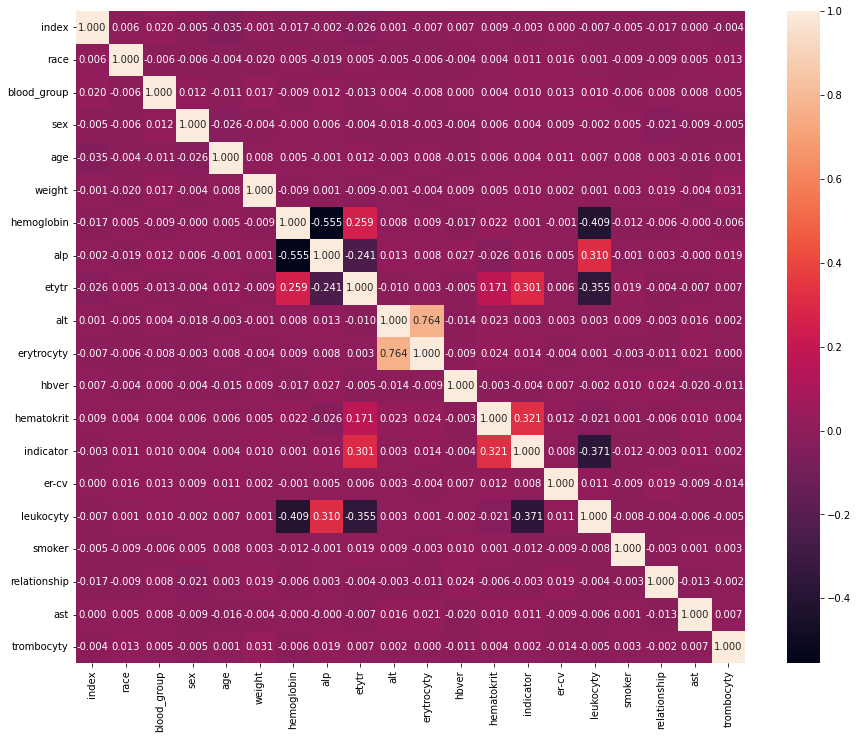

In [20]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_median.corr(), ax=ax, annot=True, fmt=".3f")

##### Nahradenie kNN

In [21]:
merged_knn = replaceNaN(merged, "mean", na_cols)
merged_knn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         10002 non-null  int64         
 1   race          10002 non-null  int32         
 2   residence     10002 non-null  object        
 3   job           10002 non-null  object        
 4   birthdate     10002 non-null  datetime64[ns]
 5   company       10002 non-null  object        
 6   blood_group   10002 non-null  int32         
 7   sex           10002 non-null  int32         
 8   name          10002 non-null  object        
 9   age           10002 non-null  int64         
 10  weight        10002 non-null  float64       
 11  hemoglobin    10002 non-null  float64       
 12  alp           10002 non-null  float64       
 13  etytr         10002 non-null  float64       
 14  alt           10002 non-null  float64       
 15  erytrocyty    10002 non-null  float6

<AxesSubplot:>

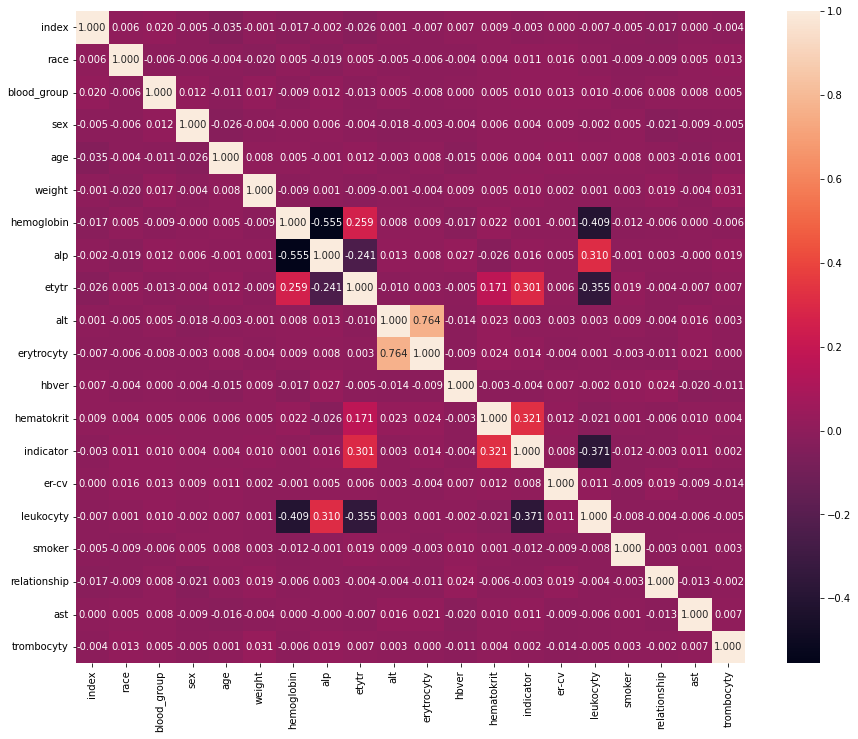

In [22]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_knn.corr(), ax=ax, annot=True, fmt=".3f")

In [23]:
merged_mean.corr() - merged_median.corr()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
index,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.309927e-05,-0.000006,-6.112278e-06,0.000103,-7.590960e-07,-1.881490e-07,-0.000022,0.000000e+00,6.184470e-07,0.000116,0.000000e+00,0.000000e+00,8.451716e-07,1.143090e-06
race,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.738929e-05,-0.000023,-1.375642e-06,-0.000094,3.882981e-06,6.911578e-07,-0.000048,0.000000e+00,-1.995276e-06,0.000107,0.000000e+00,0.000000e+00,-3.493862e-06,-4.252607e-07
blood_group,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.102259e-05,-0.000016,-3.656487e-06,0.000106,-1.818350e-06,-8.554363e-07,0.000034,0.000000e+00,-1.819620e-06,-0.000070,0.000000e+00,0.000000e+00,-3.290237e-06,-3.813291e-07
sex,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.229058e-06,-0.000027,5.841383e-06,0.000155,3.102235e-06,6.416648e-07,-0.000002,0.000000e+00,4.711496e-07,-0.000058,0.000000e+00,0.000000e+00,4.265989e-06,-2.167064e-07
age,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.090972e-05,0.000014,-1.374488e-06,0.000321,-2.216576e-06,6.125230e-07,0.000006,0.000000e+00,2.369953e-07,-0.000019,0.000000e+00,0.000000e+00,4.315847e-06,5.116535e-07
weight,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.202691e-06,0.000002,-4.009885e-06,0.000295,1.554878e-06,6.630011e-07,-0.000007,0.000000e+00,1.326511e-06,-0.000107,0.000000e+00,0.000000e+00,-1.785412e-06,-7.557277e-07
hemoglobin,1.309927e-05,3.738929e-05,2.102259e-05,-2.229058e-06,-2.090972e-05,1.202691e-06,0.000000e+00,0.000012,-1.187615e-05,0.000190,-2.466474e-05,-3.460956e-05,-0.000051,-2.942349e-05,2.852346e-05,-0.000054,-3.133367e-05,9.577964e-06,2.862227e-05,6.943692e-07
alp,-6.056316e-06,-2.328802e-05,-1.603580e-05,-2.685806e-05,1.377329e-05,2.156200e-06,1.220455e-05,0.000000,1.879684e-05,-0.000240,-9.477205e-06,-8.609679e-06,-0.000015,-3.155563e-05,-4.514591e-05,0.000006,2.152900e-05,-1.273872e-05,-4.938794e-06,-2.882502e-06
etytr,-6.112278e-06,-1.375642e-06,-3.656487e-06,5.841383e-06,-1.374488e-06,-4.009885e-06,-1.187615e-05,0.000019,0.000000e+00,-0.000012,-9.329813e-06,9.841510e-07,0.000010,-4.376556e-06,7.398149e-06,-0.000179,4.513961e-08,1.436509e-06,-1.263523e-05,1.556074e-06
alt,1.025391e-04,-9.435332e-05,1.056895e-04,1.547290e-04,3.205071e-04,2.951931e-04,1.901618e-04,-0.000240,-1.196076e-05,0.000000,8.005797e-05,-2.272546e-04,0.000090,2.466538e-04,1.408327e-04,-0.000304,2.113607e-04,-1.606015e-04,2.085276e-04,1.234114e-04


In [24]:
merged_mean.corr() - merged_knn.corr()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
index,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
race,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
blood_group,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
age,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weight,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hemoglobin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
etytr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
merged_median.corr() - merged_knn.corr()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
index,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.309927e-05,0.000006,6.112278e-06,-0.000103,7.590960e-07,1.881490e-07,0.000022,0.000000e+00,-6.184470e-07,-0.000116,0.000000e+00,0.000000e+00,-8.451716e-07,-1.143090e-06
race,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.738929e-05,0.000023,1.375642e-06,0.000094,-3.882981e-06,-6.911578e-07,0.000048,0.000000e+00,1.995276e-06,-0.000107,0.000000e+00,0.000000e+00,3.493862e-06,4.252607e-07
blood_group,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.102259e-05,0.000016,3.656487e-06,-0.000106,1.818350e-06,8.554363e-07,-0.000034,0.000000e+00,1.819620e-06,0.000070,0.000000e+00,0.000000e+00,3.290237e-06,3.813291e-07
sex,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.229058e-06,0.000027,-5.841383e-06,-0.000155,-3.102235e-06,-6.416648e-07,0.000002,0.000000e+00,-4.711496e-07,0.000058,0.000000e+00,0.000000e+00,-4.265989e-06,2.167064e-07
age,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.090972e-05,-0.000014,1.374488e-06,-0.000321,2.216576e-06,-6.125230e-07,-0.000006,0.000000e+00,-2.369953e-07,0.000019,0.000000e+00,0.000000e+00,-4.315847e-06,-5.116535e-07
weight,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.202691e-06,-0.000002,4.009885e-06,-0.000295,-1.554878e-06,-6.630011e-07,0.000007,0.000000e+00,-1.326511e-06,0.000107,0.000000e+00,0.000000e+00,1.785412e-06,7.557277e-07
hemoglobin,-1.309927e-05,-3.738929e-05,-2.102259e-05,2.229058e-06,2.090972e-05,-1.202691e-06,0.000000e+00,-0.000012,1.187615e-05,-0.000190,2.466474e-05,3.460956e-05,0.000051,2.942349e-05,-2.852346e-05,0.000054,3.133367e-05,-9.577964e-06,-2.862227e-05,-6.943692e-07
alp,6.056316e-06,2.328802e-05,1.603580e-05,2.685806e-05,-1.377329e-05,-2.156200e-06,-1.220455e-05,0.000000,-1.879684e-05,0.000240,9.477205e-06,8.609679e-06,0.000015,3.155563e-05,4.514591e-05,-0.000006,-2.152900e-05,1.273872e-05,4.938794e-06,2.882502e-06
etytr,6.112278e-06,1.375642e-06,3.656487e-06,-5.841383e-06,1.374488e-06,4.009885e-06,1.187615e-05,-0.000019,0.000000e+00,0.000012,9.329813e-06,-9.841510e-07,-0.000010,4.376556e-06,-7.398149e-06,0.000179,-4.513961e-08,-1.436509e-06,1.263523e-05,-1.556074e-06
alt,-1.025391e-04,9.435332e-05,-1.056895e-04,-1.547290e-04,-3.205071e-04,-2.951931e-04,-1.901618e-04,0.000240,1.196076e-05,0.000000,-8.005797e-05,2.272546e-04,-0.000090,-2.466538e-04,-1.408327e-04,0.000304,-2.113607e-04,1.606015e-04,-2.085276e-04,-1.234114e-04


### Vychýlené dáta

In [26]:
merged_num_only = merged_withoutNA.drop(["residence", "job", "company", "name", "birthdate"], axis=1)

index              AxesSubplot(0.125,0.787927;0.227941x0.0920732)
race            AxesSubplot(0.398529,0.787927;0.227941x0.0920732)
blood_group     AxesSubplot(0.672059,0.787927;0.227941x0.0920732)
sex                AxesSubplot(0.125,0.677439;0.227941x0.0920732)
age             AxesSubplot(0.398529,0.677439;0.227941x0.0920732)
weight          AxesSubplot(0.672059,0.677439;0.227941x0.0920732)
hemoglobin         AxesSubplot(0.125,0.566951;0.227941x0.0920732)
alp             AxesSubplot(0.398529,0.566951;0.227941x0.0920732)
etytr           AxesSubplot(0.672059,0.566951;0.227941x0.0920732)
alt                AxesSubplot(0.125,0.456463;0.227941x0.0920732)
erytrocyty      AxesSubplot(0.398529,0.456463;0.227941x0.0920732)
hbver           AxesSubplot(0.672059,0.456463;0.227941x0.0920732)
hematokrit         AxesSubplot(0.125,0.345976;0.227941x0.0920732)
indicator       AxesSubplot(0.398529,0.345976;0.227941x0.0920732)
er-cv           AxesSubplot(0.672059,0.345976;0.227941x0.0920732)
leukocyty 

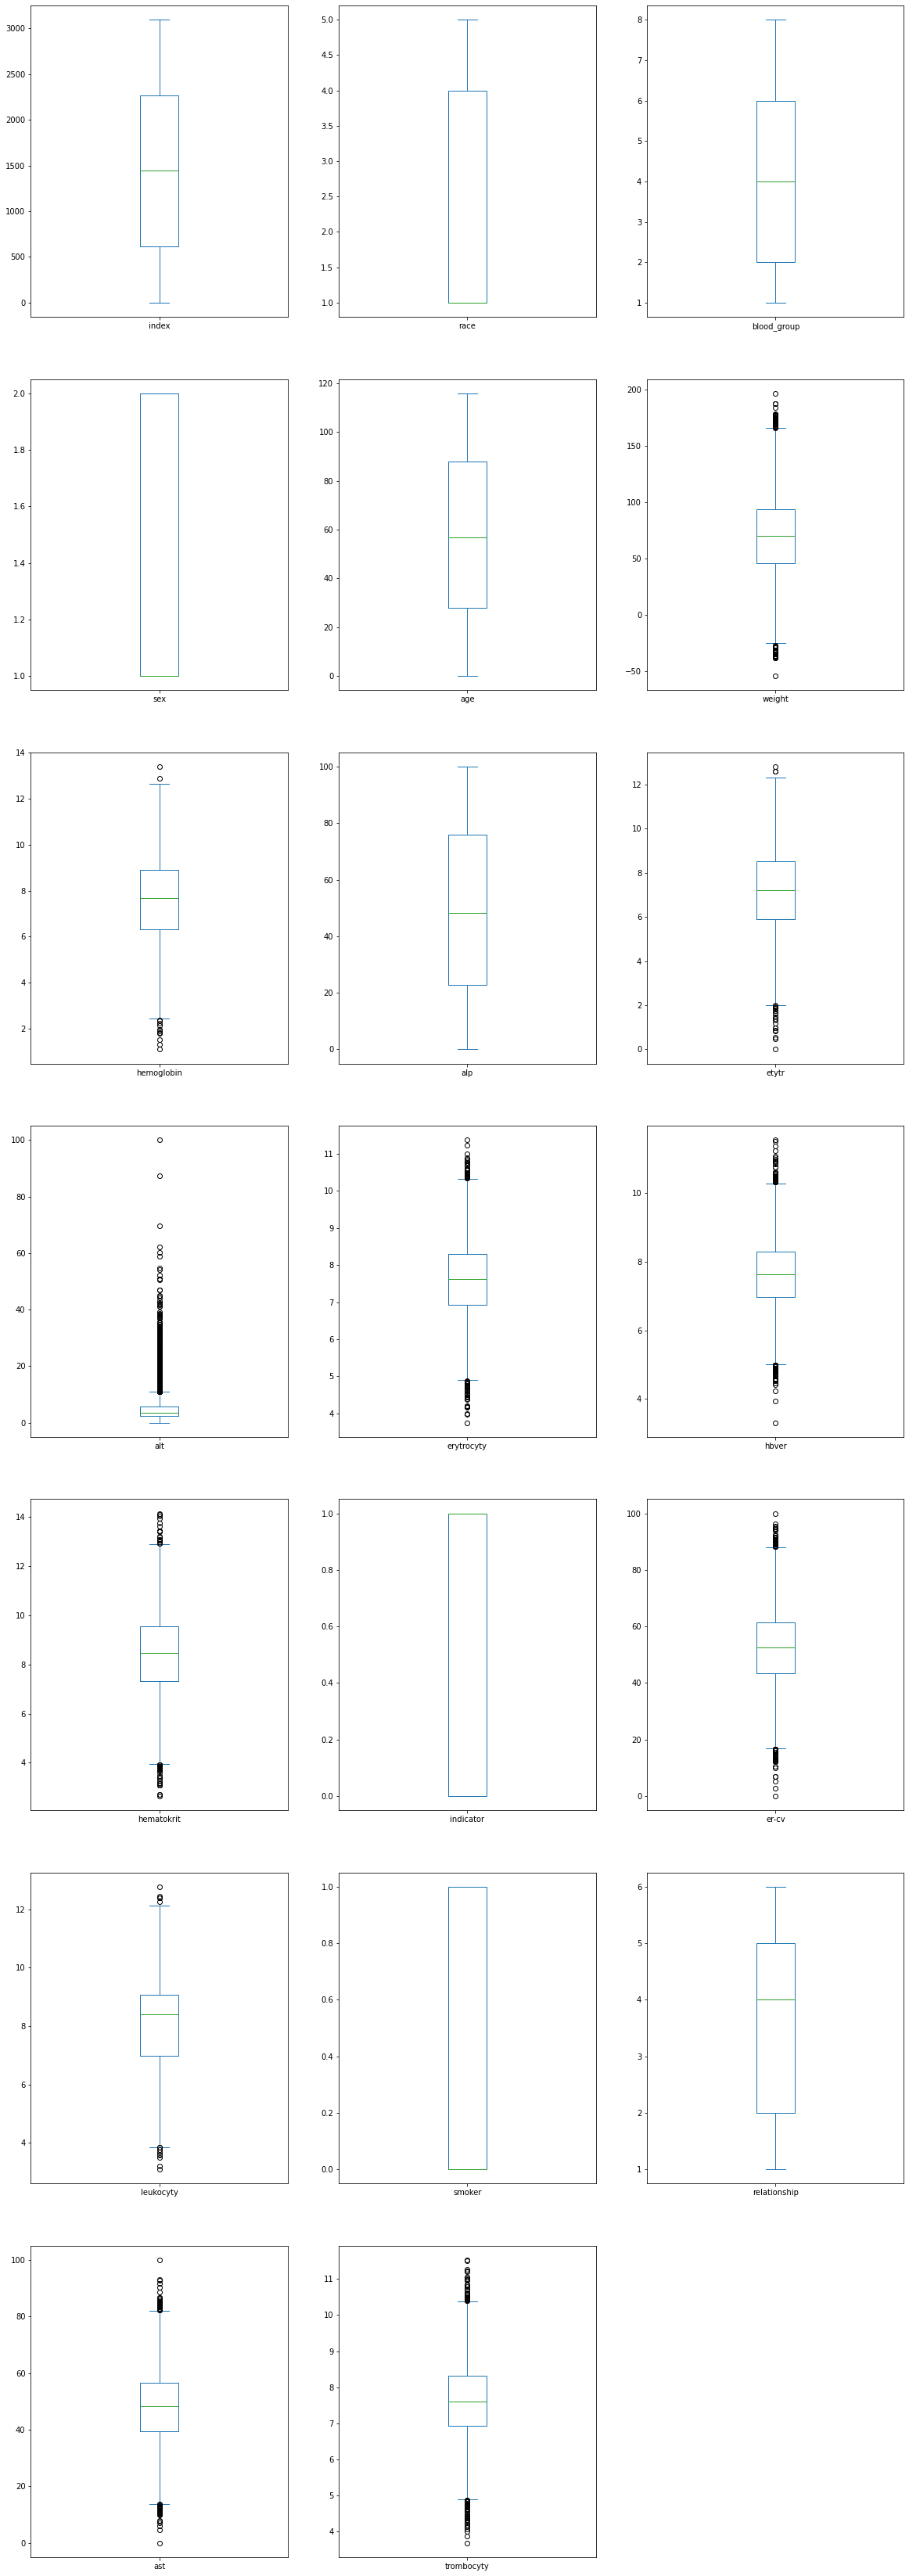

In [27]:
merged_num_only.plot(kind='box', subplots=True, layout=(7, 3), sharex=False, sharey=False, figsize=(20, 60))

#### Identifikácia vychýlených hodnôt

In [28]:
def identify_outliers(merged):
    suma = 0;
    for col in merged.columns:
        q25, q75 = percentile(merged[col], 25), percentile(merged[col], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outliers = merged[((merged[col] < lower) | (merged[col] > upper))] 
        print(col, 'Identified outliers: %d' % len(outliers))
        suma += len(outliers)
    print('Sum of identified outliers: %d' % suma)

In [29]:
identify_outliers(merged_num_only)

index Identified outliers: 0
race Identified outliers: 0
blood_group Identified outliers: 0
sex Identified outliers: 0
age Identified outliers: 0
weight Identified outliers: 53
hemoglobin Identified outliers: 13
alp Identified outliers: 0
etytr Identified outliers: 23
alt Identified outliers: 767
erytrocyty Identified outliers: 65
hbver Identified outliers: 73
hematokrit Identified outliers: 48
indicator Identified outliers: 0
er-cv Identified outliers: 64
leukocyty Identified outliers: 14
smoker Identified outliers: 0
relationship Identified outliers: 0
ast Identified outliers: 54
trombocyty Identified outliers: 73
Sum of identified outliers: 1247


#### Odstránenie vychýlených (odľahlých) pozorovaní

In [30]:
def remove_outliers(merged):
    newMerged = merged.copy()
    for col in newMerged.columns:
        q25, q75 = percentile(newMerged[col], 25), percentile(newMerged[col], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        newMerged = newMerged[((newMerged[col] >= lower) & (newMerged[col] <= upper))] 
    return newMerged

In [31]:
merged_withoutOut = remove_outliers(merged_num_only)
merged_withoutOut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8491 entries, 0 to 10001
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         8491 non-null   int64  
 1   race          8491 non-null   int32  
 2   blood_group   8491 non-null   int32  
 3   sex           8491 non-null   int32  
 4   age           8491 non-null   int64  
 5   weight        8491 non-null   float64
 6   hemoglobin    8491 non-null   float64
 7   alp           8491 non-null   float64
 8   etytr         8491 non-null   float64
 9   alt           8491 non-null   float64
 10  erytrocyty    8491 non-null   float64
 11  hbver         8491 non-null   float64
 12  hematokrit    8491 non-null   float64
 13  indicator     8491 non-null   float64
 14  er-cv         8491 non-null   float64
 15  leukocyty     8491 non-null   float64
 16  smoker        8491 non-null   int64  
 17  relationship  8491 non-null   int32  
 18  ast           8491 non-null

<AxesSubplot:>

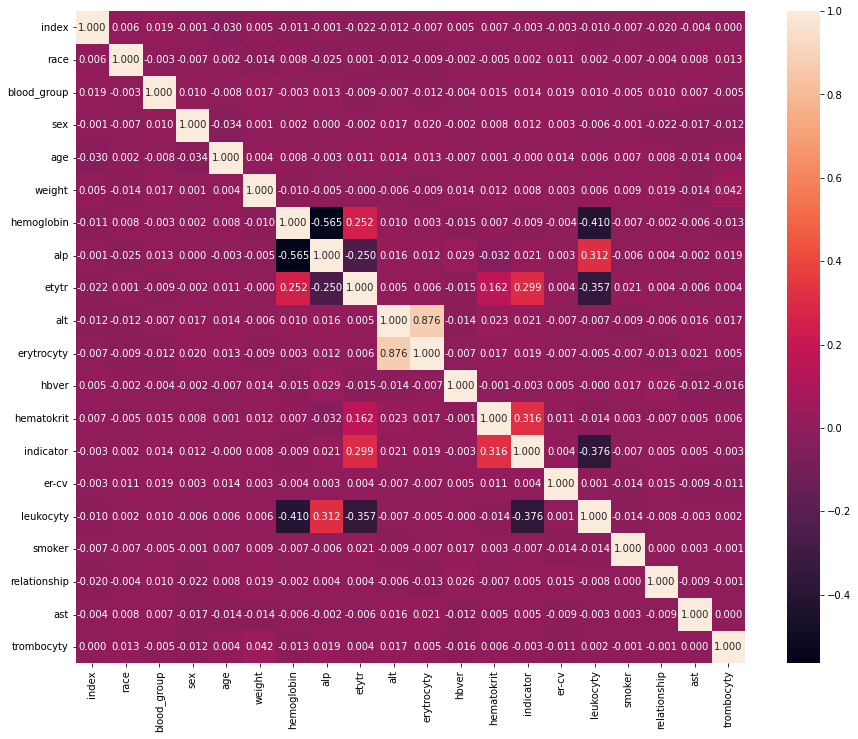

In [32]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_withoutOut.corr(), ax=ax, annot=True, fmt=".3f")

In [33]:
merged_num_only.corr() - merged_withoutOut.corr()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
index,0.000000,-0.000274,0.000640,-0.004514,-0.002998,-0.008873,-0.007454,0.002406,-0.006193,0.010331,0.000212,0.005549,-0.003002,-0.005585,0.003169,0.007169,0.000891,0.001654,0.004428,-0.005014
race,-0.000274,0.000000,-0.004696,-0.002016,-0.004684,-0.004432,-0.001747,0.006695,0.000955,0.001687,-0.002373,-0.000585,0.008911,0.008991,0.007788,-0.000483,-0.001143,-0.004415,-0.003259,0.001527
blood_group,0.000640,-0.004696,0.000000,0.003407,-0.001938,-0.001360,-0.003944,0.000264,-0.001637,0.013597,0.005912,0.003059,-0.008116,-0.003622,-0.005848,0.001075,0.000129,-0.002645,0.004061,0.010113
sex,-0.004514,-0.002016,0.003407,0.000000,0.009014,0.000446,-0.000973,0.004204,-0.003940,-0.036194,-0.024462,-0.003512,-0.003289,-0.005325,0.003511,0.003769,0.004916,-0.000046,0.007790,0.005598
age,-0.002998,-0.004684,-0.001938,0.009014,0.000000,0.001228,-0.003344,0.003505,0.000394,-0.014747,-0.003983,-0.004242,0.005237,0.003210,-0.000949,-0.001140,0.000787,-0.005069,-0.001761,0.000339
weight,-0.008873,-0.004432,-0.001360,0.000446,0.001228,0.000000,0.003603,0.004537,-0.006841,0.005640,0.003884,-0.005103,-0.007694,-0.001491,-0.004878,-0.003199,-0.006708,0.000346,0.006172,-0.006635
hemoglobin,-0.007454,-0.001747,-0.003944,-0.000973,-0.003344,0.003603,0.000000,0.009970,0.008329,-0.001933,0.004619,-0.001961,0.012156,0.008881,0.002954,0.000451,-0.004779,-0.004735,0.006024,0.004767
alp,0.002406,0.006695,0.000264,0.004204,0.003505,0.004537,0.009970,0.000000,0.008160,-0.002437,-0.002422,-0.002618,0.006475,-0.002063,0.000455,-0.001105,0.004255,-0.000890,-0.001283,0.001428
etytr,-0.006193,0.000955,-0.001637,-0.003940,0.000394,-0.006841,0.008329,0.008160,0.000000,-0.014571,-0.004100,0.006201,0.009059,0.003646,-0.001004,0.002754,-0.000575,-0.009310,0.001272,-0.001601
alt,0.010331,0.001687,0.013597,-0.036194,-0.014747,0.005640,-0.001933,-0.002437,-0.014571,0.000000,-0.109161,0.001630,-0.000462,-0.018294,0.011257,0.012570,0.016214,0.002224,-0.003040,-0.014569


#### Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

In [34]:
def replace_outliers(merged):
    newMerged = merged.copy()
    for col in newMerged.columns:
        q05, q95 = percentile(newMerged[col], 5), percentile(newMerged[col], 95)
        newMerged[col] = np.where(newMerged[col] < q05, q05, newMerged[col])
        newMerged[col] = np.where(newMerged[col] > q95, q95, newMerged[col])
    return newMerged

In [35]:
merged_replacedOut = replace_outliers(merged_num_only)

In [36]:
merged_replacedOut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9672 entries, 0 to 10001
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         9672 non-null   float64
 1   race          9672 non-null   float64
 2   blood_group   9672 non-null   float64
 3   sex           9672 non-null   float64
 4   age           9672 non-null   float64
 5   weight        9672 non-null   float64
 6   hemoglobin    9672 non-null   float64
 7   alp           9672 non-null   float64
 8   etytr         9672 non-null   float64
 9   alt           9672 non-null   float64
 10  erytrocyty    9672 non-null   float64
 11  hbver         9672 non-null   float64
 12  hematokrit    9672 non-null   float64
 13  indicator     9672 non-null   float64
 14  er-cv         9672 non-null   float64
 15  leukocyty     9672 non-null   float64
 16  smoker        9672 non-null   float64
 17  relationship  9672 non-null   float64
 18  ast           9672 non-null

In [37]:
identify_outliers(merged_replacedOut)

index Identified outliers: 0
race Identified outliers: 0
blood_group Identified outliers: 0
sex Identified outliers: 0
age Identified outliers: 0
weight Identified outliers: 0
hemoglobin Identified outliers: 0
alp Identified outliers: 0
etytr Identified outliers: 0
alt Identified outliers: 767
erytrocyty Identified outliers: 0
hbver Identified outliers: 0
hematokrit Identified outliers: 0
indicator Identified outliers: 0
er-cv Identified outliers: 0
leukocyty Identified outliers: 0
smoker Identified outliers: 0
relationship Identified outliers: 0
ast Identified outliers: 0
trombocyty Identified outliers: 0
Sum of identified outliers: 767


index              AxesSubplot(0.125,0.787927;0.227941x0.0920732)
race            AxesSubplot(0.398529,0.787927;0.227941x0.0920732)
blood_group     AxesSubplot(0.672059,0.787927;0.227941x0.0920732)
sex                AxesSubplot(0.125,0.677439;0.227941x0.0920732)
age             AxesSubplot(0.398529,0.677439;0.227941x0.0920732)
weight          AxesSubplot(0.672059,0.677439;0.227941x0.0920732)
hemoglobin         AxesSubplot(0.125,0.566951;0.227941x0.0920732)
alp             AxesSubplot(0.398529,0.566951;0.227941x0.0920732)
etytr           AxesSubplot(0.672059,0.566951;0.227941x0.0920732)
alt                AxesSubplot(0.125,0.456463;0.227941x0.0920732)
erytrocyty      AxesSubplot(0.398529,0.456463;0.227941x0.0920732)
hbver           AxesSubplot(0.672059,0.456463;0.227941x0.0920732)
hematokrit         AxesSubplot(0.125,0.345976;0.227941x0.0920732)
indicator       AxesSubplot(0.398529,0.345976;0.227941x0.0920732)
er-cv           AxesSubplot(0.672059,0.345976;0.227941x0.0920732)
leukocyty 

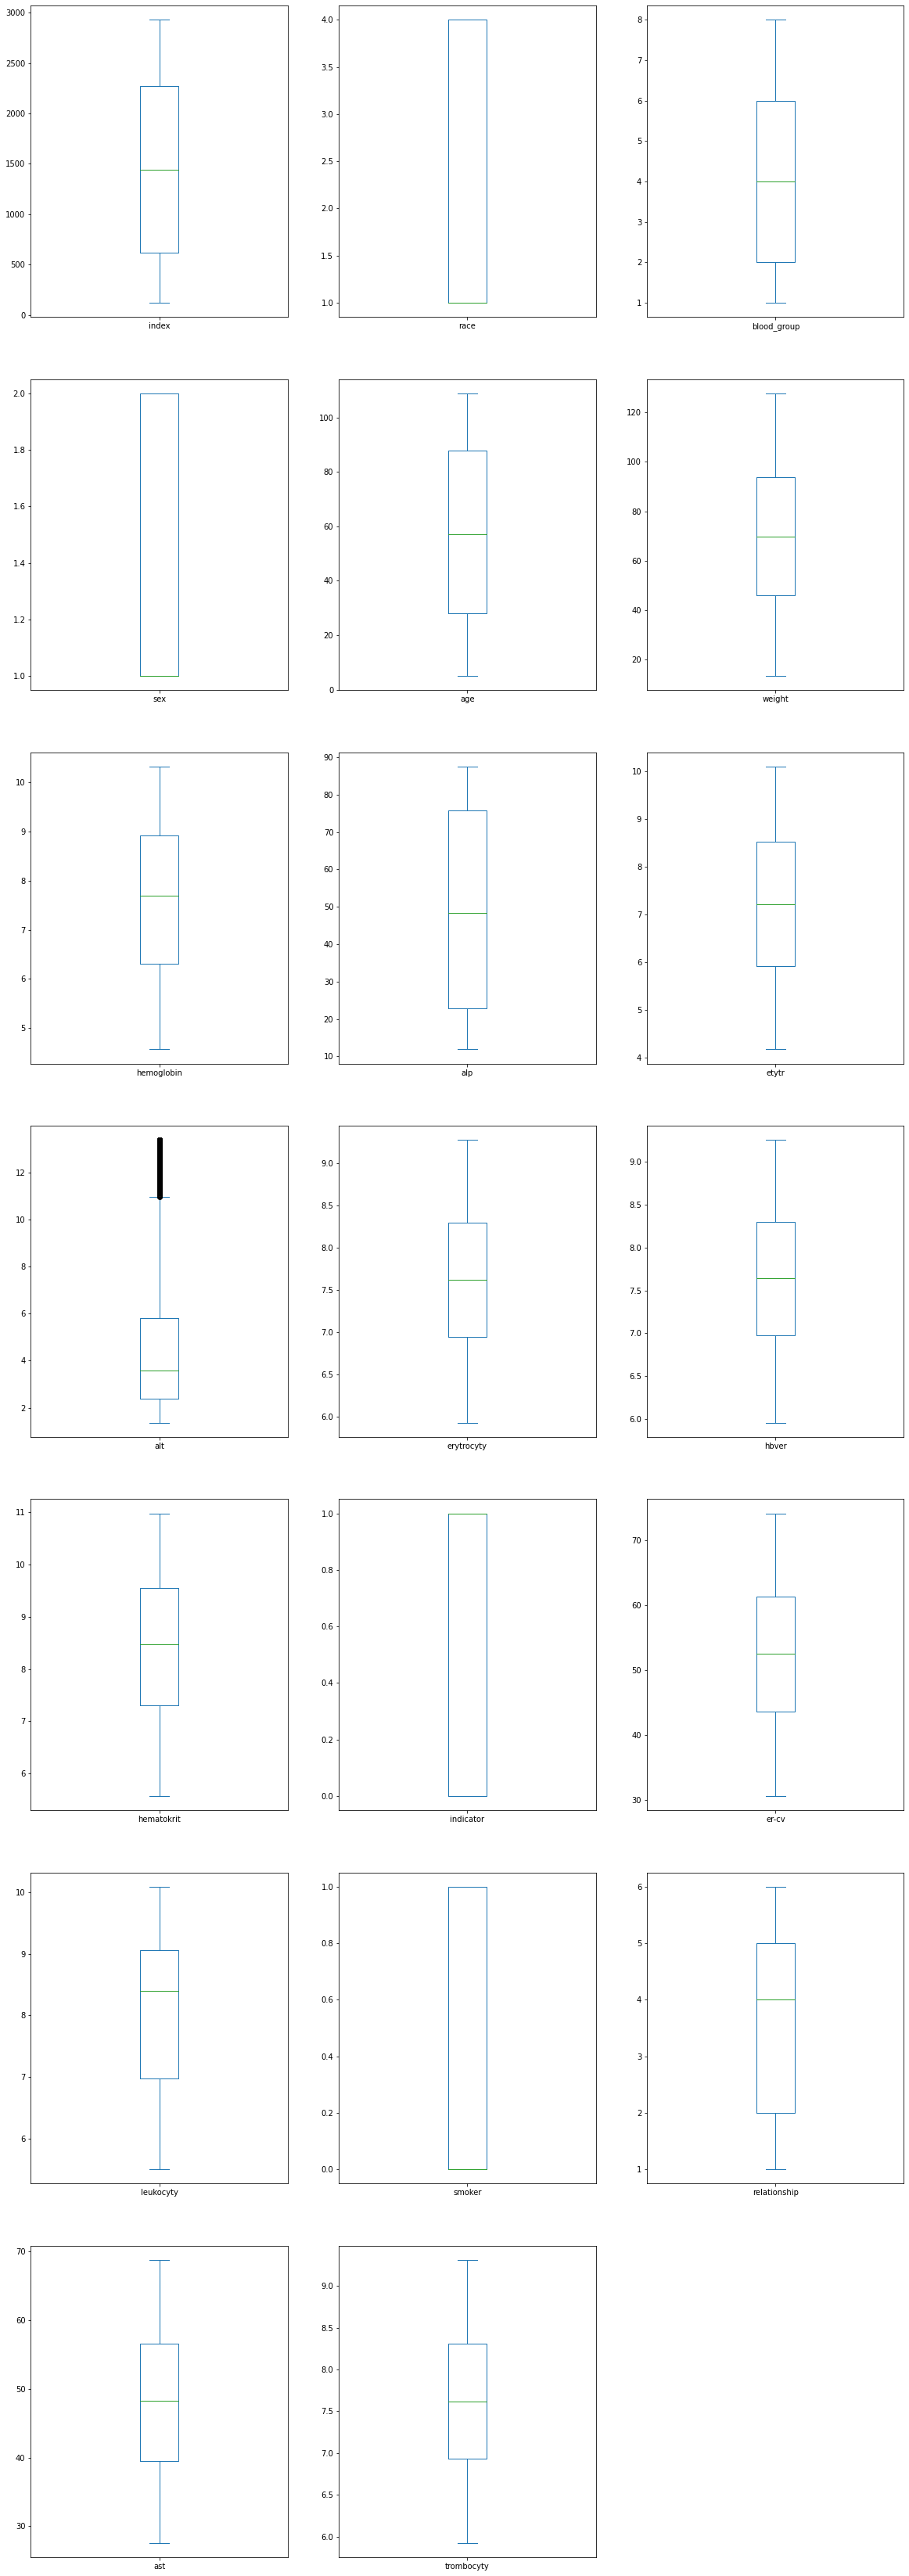

In [38]:
merged_replacedOut.plot(kind='box', subplots=True, layout=(7, 3), sharex=False, sharey=False, figsize=(20, 60))

<AxesSubplot:>

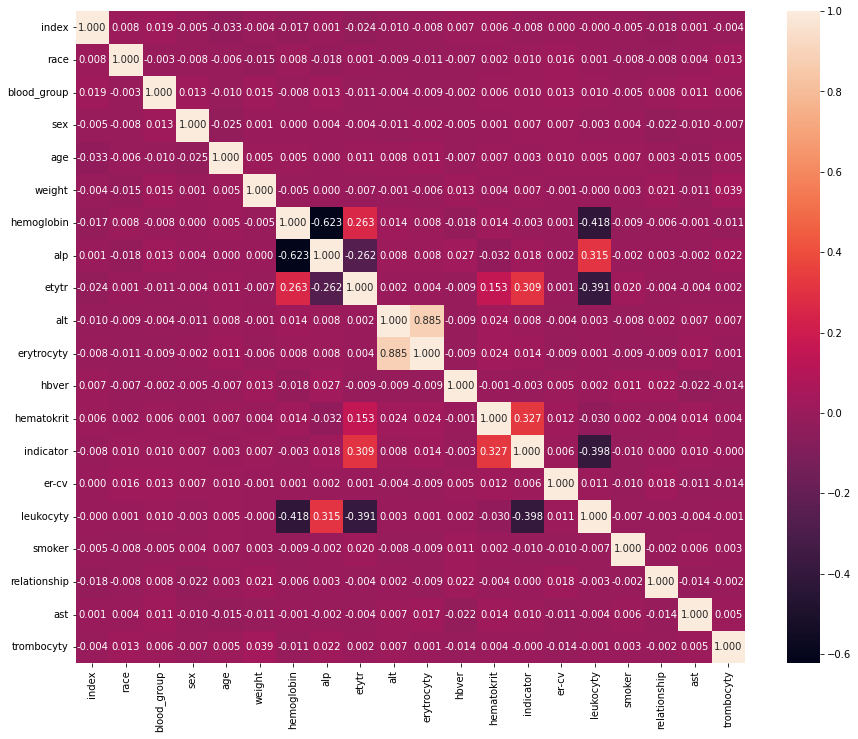

In [39]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(merged_replacedOut.corr(), ax=ax, annot=True, fmt=".3f")

In [40]:
merged_num_only.corr() - merged_replacedOut.corr()

,index,race,blood_group,sex,age,weight,hemoglobin,alp,etytr,alt,erytrocyty,hbver,hematokrit,indicator,er-cv,leukocyty,smoker,relationship,ast,trombocyty
index,0.000000,-0.002336,0.000389,-0.000898,0.000053,0.000782,-0.001186,0.000138,-0.004621,0.007838,0.001093,0.002794,-0.001363,-0.000258,-0.000057,-0.002578,-0.000814,0.000059,-0.000413,-0.000365
race,-0.002336,0.000000,-0.004958,-0.001256,0.003112,-0.003661,-0.001836,-0.000639,0.000872,-0.000878,-0.000305,0.004180,0.002471,0.000606,0.002849,0.000375,0.000159,0.000102,0.000567,0.002278
blood_group,0.000389,-0.004958,0.000000,0.000000,-0.000190,0.000513,0.001078,0.000118,0.000042,0.009963,0.002709,0.001418,0.000748,0.000000,-0.000485,0.001165,0.000000,0.000000,-0.000082,-0.000944
sex,-0.000898,-0.001256,0.000000,0.000000,0.000515,0.000308,0.000987,0.000026,-0.001522,-0.008403,-0.002597,-0.000929,0.004113,0.000000,0.000123,0.001090,0.000000,0.000000,0.000744,0.000789
age,0.000053,0.003112,-0.000190,0.000515,0.000000,0.000120,0.000016,-0.000460,0.000969,-0.008627,-0.002150,-0.004694,-0.000228,-0.000325,0.003055,0.000496,-0.000013,0.000148,-0.000472,-0.000441
weight,0.000782,-0.003661,0.000513,0.000308,0.000120,0.000000,-0.001401,-0.000416,0.000227,0.001021,0.000463,-0.003945,0.000694,0.000409,-0.000812,0.003356,-0.000233,-0.001380,0.003349,-0.003844
hemoglobin,-0.001186,-0.001836,0.001078,0.000987,0.000016,-0.001401,0.000000,0.067983,-0.003145,-0.006682,-0.000446,0.000895,0.005089,0.002842,-0.002307,0.009191,-0.002590,-0.000406,0.001672,0.002441
alp,0.000138,-0.000639,0.000118,0.000026,-0.000460,-0.000416,0.067983,0.000000,0.020227,0.005948,0.001783,-0.000719,0.005858,0.000377,0.001528,-0.004638,0.000356,0.000092,-0.000490,-0.001075
etytr,-0.004621,0.000872,0.000042,-0.001522,0.000969,0.000227,-0.003145,0.020227,0.000000,-0.011989,-0.002535,0.000305,0.018334,-0.006553,0.001859,0.036345,0.000612,-0.001220,-0.000849,0.000727
alt,0.007838,-0.000878,0.009963,-0.008403,-0.008627,0.001021,-0.006682,0.005948,-0.011989,0.000000,-0.118589,-0.003240,-0.001048,-0.005677,0.008685,0.002509,0.015574,-0.006270,0.006143,-0.004103


Ďalej budeme pracovať s dátami, kde boli chýbajúce dáta odstránené a vychýlené hodnoty neboli nijako ošetrené. V *merged_withoutNA* sa nachádzajú všetky dáta z *merged* a NA hodnoty sú odstránené. V *merged_num_only* sa nachádzajú všetky dáta z *merged_withoutNA* s tým, že sú odstránené nenumerické stĺpce *residence, job, company, name, birthdate*.

### Záver integrácie a čistenia dát

Chýbajúcich dát je celkovo 330. Pri stĺpcoch ktoré majú 10000+ záznamov to je irelevantné číslo. Chýbajúce dáta tvoria iba 3,3% dát, preto je bezpečné ich odtrániť s minimálnou hrozbou výrazného ovplyvnenia výsledkov. Vyskúšali sme nahradiť chýbajúce hodnoty priemerom, mediánom a kNN, ale zmeny v koreláciách boli minimálne. Preto sme sa rozhodli naďalej pokračovať s datasetom z ktorého vychýlené hodnoty odstránime.

Vychýlené hodnoty sú prítomné, ide ale o medicínske dáta ľudí s rôznym zdravotným stavom. To, či sú nejaké hodnoty z krvných testov nezmyselné, nedokážeme posúdiť z dôvodu nedostatku doménových znalostí. Vyskúšali sme vychýlené dáta odstrániť, prípadne ich nahradiť hraničnými hodnotami rozdelenia (5% resp. 95%). Zmeny v koreláciách boli prítomné, avšak podľa nášho názoru manipulácia s výchýlenými dátami nie je bezpečná, keďže nevieme, či sú dáta vychýlené z dôvodu chyby, alebo z dôvodu skutočne vychýlenej hodnoty. Naďalej budeme predpolkadať, že dáta sú vychýlené preto, lebo boli tak namerané aj v skutočnosti. Preto ich nebudeme odstraňovať ani nahrádzať. 

## 2. Realizácia predspracovania dát (5b)


* Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu (train and test mergedset) podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím mergedsetom.
* Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

## 3. Výber atribútov pre strojové učenie (5b)

* Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “indikator”. Zoradíte tie atribúty v poradí podľa dôležitosti. 
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

## 4. Replikovateľnosť predspracovania (5b)

* Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny (napr. pomocou funkcie/í)
* Očakáva sa aj využitie možnosti sklearn.pipeline

Správa sa odovzdáva v 9. týždni semestra

Na cvičení, dvojica svojmu cvičiacemu odprezentuje vykonanú prieskumnú analýzu v Jupyter Notebooku.
Správu elektronicky odovzdá jeden člen z dvojice do systému AIS do nedele 21.11.2021 23:59.